#### As of 11/30 to actually run this you'll need to do the following (I think) to alter the environment:
jupyter labextension install @jupyter-widgets/jupyterlab-manager  (This will take a few minutes)

jupyter nbextension enable --py --sys-prefix widgetsnbextension

jupyter nbextension enable --py widgetsnbextension

You may only have to run 1 out of the last two commands. After doing all this you'll need to restart your jupyter lab/notebook
We'll have to discuss if a) we want to use ipywidgets, and b) if so, how do we go about adding this stuff to the environment.yml file. Or do we write a script that does it

### Import things

In [16]:
import air as air
import ipywidgets as widgets
from ipywidgets import Layout
import matcher as match
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
import scipy.stats as sc_stats
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load in our data using existing functions

In [2]:
%autoreload
sensor_data = air.files_to_dataframe(glob.glob('../data/purple_air/*'))
matched_ses_data = match.station_matcher(sensor_data)

### Get mean AQI

In [3]:
%autoreload
matched_ses_data['mean_aqi'] = matched_ses_data.apply(lambda row: air.get_tract_mean_aqi(row), axis=1)
matched_ses_data['exp100'] = matched_ses_data.apply(lambda row: air.get_tract_exposure(row, 100), axis=1)
matched_ses_data['exp150'] = matched_ses_data.apply(lambda row: air.get_tract_exposure(row, 150), axis=1)
matched_ses_data['mean_aqi_ns'] = matched_ses_data.apply(lambda row: air.get_tract_mean_aqi(row, include_smoke=False), axis=1)
matched_ses_data['exp100_ns'] = matched_ses_data.apply(lambda row: air.get_tract_exposure(row, 100, include_smoke=False), axis=1)
matched_ses_data['exp150_ns'] = matched_ses_data.apply(lambda row: air.get_tract_exposure(row, 150, include_smoke=False), axis=1)


## Now plot stuff!

Text(0.5, 1.0, 'Sensor counts by census tract')

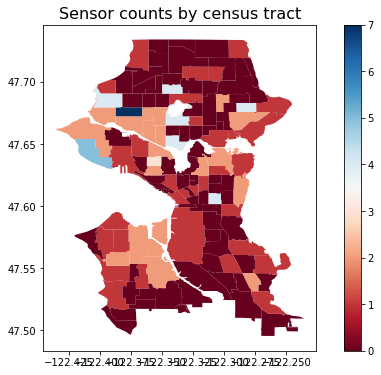

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))
counts_plot = matched_ses_data.plot(column='sensor_counts', cmap='RdBu', legend=True, ax=ax)
plt.title('Sensor counts by census tract', fontsize=16)

Text(0.5, 1.0, 'Exposure to AQI>=150 (no fires; min/day)')

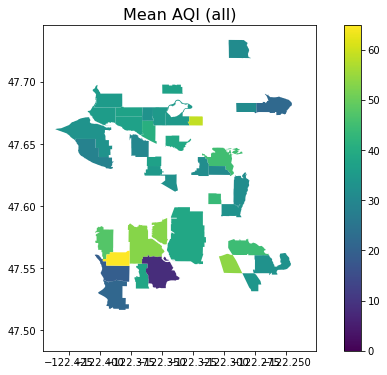

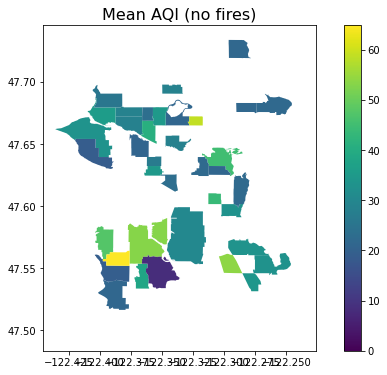

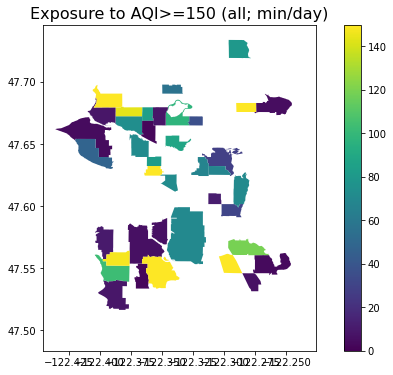

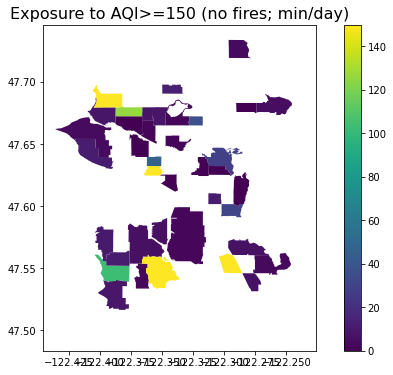

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
counts_plot = matched_ses_data.plot(column='mean_aqi', legend=True, ax=ax, norm=colors.Normalize(0,65))
plt.title('Mean AQI (all)', fontsize=16)

fig, ax = plt.subplots(figsize=(10, 6))
counts_plot = matched_ses_data.plot(column='mean_aqi_ns', legend=True, ax=ax, norm=colors.Normalize(0,65))
plt.title('Mean AQI (no fires)', fontsize=16)

fig, ax = plt.subplots(figsize=(10, 6))
counts_plot = matched_ses_data.plot(column='exp150', legend=True, ax=ax, norm=colors.Normalize(0,150))
plt.title('Exposure to AQI>=150 (all; min/day)', fontsize=16)

fig, ax = plt.subplots(figsize=(10, 6))
counts_plot = matched_ses_data.plot(column='exp150_ns', legend=True, ax=ax, norm=colors.Normalize(0,150))
plt.title('Exposure to AQI>=150 (no fires; min/day)', fontsize=16)



### Some info on what different data exists in the SES dataset
All info is here: https://data-seattlecitygis.opendata.arcgis.com/datasets/racial-and-social-equity-composite-index <br>
Note: Maybe we should rename some of these! I also may be wrong on what some of these are <br>
RACE_ELL_O: Percentage of people of color <br>
SOCIOECONO: A composite of different socioeconomic things <br>
COMPOSITE_: The composite of everything <br>
HEALTH_PER: A composite index of different health metrics

In [6]:
#Rename some columns
renamed_ses_data = matched_ses_data.rename(columns = {'RACE_ELL_O':'POC_PRCT', 'COMPOSITE_':'COMPOSITE',
                                                      'HEALTH_PER':'HEALTH', 'PCT_ENGLIS':'NON_ENGLISH',
                                                      'PCT_POP_IN':'LOW_INCOME'})

### Scatter plot to see how the number of sensors in a plot relates to different SES metrics
Note: The size of each mark is scaled by the number of such census tracts. So for tracts with lots of sensors we might only have n=1

In [7]:
ses_metric_list = ['COMPOSITE', 'SOCIOECONO', 'HEALTH', 'POC_PRCT', 'NON_ENGLISH', 'LOW_INCOME']
aqi_metric_list = ['mean_aqi','exp100', 'exp150', 'mean_aqi_ns', 'exp100_ns', 'exp150_ns']

In [26]:
def sensor_count_plotting(ses_metric):
    
    # group by the number of sensors in the tract
    grouped = renamed_ses_data.groupby('sensor_counts')
    
    # number of sensors in tract (x coordinate)
    num_sensors = np.array([name for name, group in grouped])
    
    # metric of interest (y coordinate)
    stat = np.array([group[ses_metric].mean() for name, group in grouped])
    
    # number of census tracts in the group
    tract_counts = np.array([group['OBJECTID'].count() for name, group in grouped])
    
    # regression
    slope, intercept, r_value, p_value, std_err = sc_stats.linregress(num_sensors, stat)
    
    #plot 
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(num_sensors, stat, s=tract_counts*10)
    ax.plot(num_sensors, num_sensors * slope + intercept, color='k')
    ax.text(x=0.7, y=0.9, s = 'r^2 value is: ' + str(round(r_value ** 2, 3)), fontsize=16,
             color='r', transform=ax.transAxes)
    plt.title(ses_metric + ' versus number of sensors by census tract', fontsize=18)
    plt.ylabel(ses_metric, fontsize=16)
    plt.xlabel('Sensors in census tract', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [27]:
def aqi_plotting(ses_metric, aqi_metric):
    
    # get AQI and SES data
    aqi = renamed_ses_data[aqi_metric]
    counts = renamed_ses_data[ses_metric]
    
    # regression (requires removal of NaN)
    mask = ~np.isnan(aqi) & ~np.isnan(counts)
    slope, intercept, r_value, p_value, std_err = sc_stats.linregress(aqi[mask], counts[mask])
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(aqi, counts)
    
    aqi_space = np.linspace(np.amin(aqi), np.amax(aqi))
    ax.plot(aqi_space, aqi_space * slope + intercept, color='k')
    
    ax.text(x=0.7, y=0.9, s = 'r^2 value is: ' + str(round(r_value ** 2, 3)), fontsize=16,
             color='r', transform=ax.transAxes)
    plt.title(ses_metric + ' versus ' + aqi_metric, fontsize=16)
    plt.ylabel(ses_metric, fontsize=16)
    plt.xlabel(aqi_metric, fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [28]:
widgets.interact(sensor_count_plotting,
                 ses_metric=widgets.Dropdown(
                     options=ses_metric_list,
                     description='Socioeconomic metric'))


interactive(children=(Dropdown(description='Socioeconomic metric', options=('COMPOSITE', 'SOCIOECONO', 'HEALTH…

<function __main__.sensor_count_plotting(ses_metric)>

In [29]:
widgets.interact(aqi_plotting, 
                 ses_metric=widgets.Dropdown(
                     options=ses_metric_list,
                     description='Socioeconomic metric'),
                 aqi_metric = widgets.Dropdown(
                     options=aqi_metric_list,
                     description='Air Quality Metric'))

interactive(children=(Dropdown(description='Socioeconomic metric', options=('COMPOSITE', 'SOCIOECONO', 'HEALTH…

<function __main__.aqi_plotting(ses_metric, aqi_metric)>